# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [303]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [304]:
# Import essential libraries
import os
import shutil
import random
import datetime
import numpy as np
import pandas as pd
import zipfile
from PIL import Image
import tensorflow as tf

from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout,Activation,GroupNormalization
from sklearn.model_selection  import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns


Load the dataset.

In [305]:
# Load and unzip the dataset
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('images')  # Extract to a working directory


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [306]:
# Create a function to load the raw images
def load_images_from_folder(root_dir, formats={'.jpg', '.jpeg', '.png'}):
    
    images = []
    labels = []
    
    for label in os.listdir(root_dir):
        class_path = os.path.join(root_dir, label)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            ext = os.path.splitext(file)[1].lower()
            if ext in formats:
                try:
                    img_path = os.path.join(class_path, file)
                    img = Image.open(img_path)
                    images.append(np.array(img))
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return images, labels


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [307]:
# Get the images and their labels

images, labels = load_images_from_folder("images/data")
print(f"Loaded {len(images)} images.")


Loaded 7625 images.


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [308]:
# Visualise Data Distribution
class_labels=['Food_Waste','Metal','Paper','Plastic','Other','Cardboard', 'Glass']
def visualize_dist(class_labels,labels):
    classes=[]

    for item in class_labels:
        classes.append({'Label':item, 'Count':labels.count(item)})
        
    title="Class Distribution"

    classes=pd.DataFrame(classes)


    plt.figure(figsize=(10, 6))
    sns.barplot(data=classes, x=classes.Label,y= classes.Count, hue=classes.Label)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

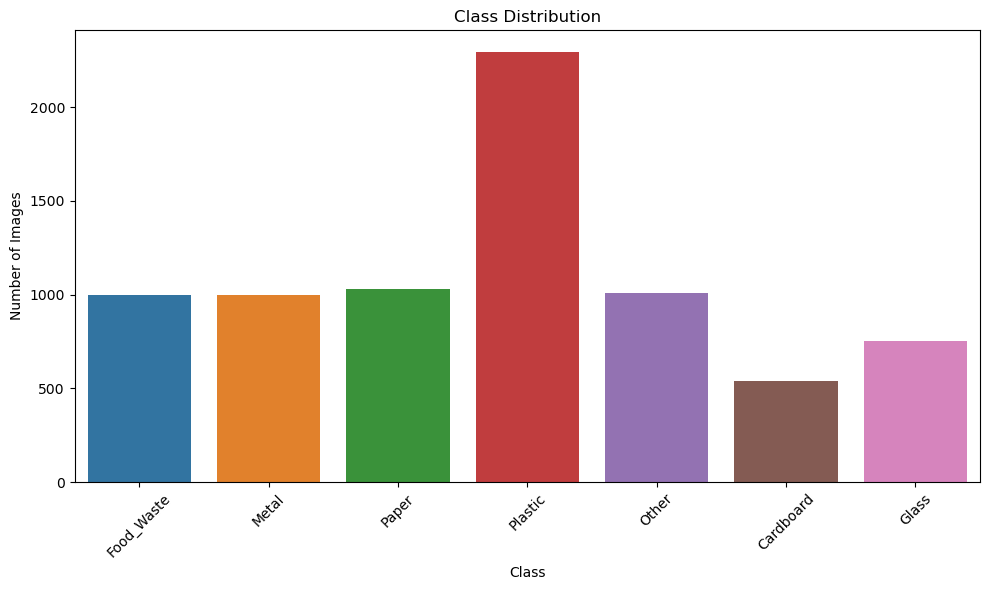

In [309]:
visualize_dist(class_labels=class_labels,labels=labels)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

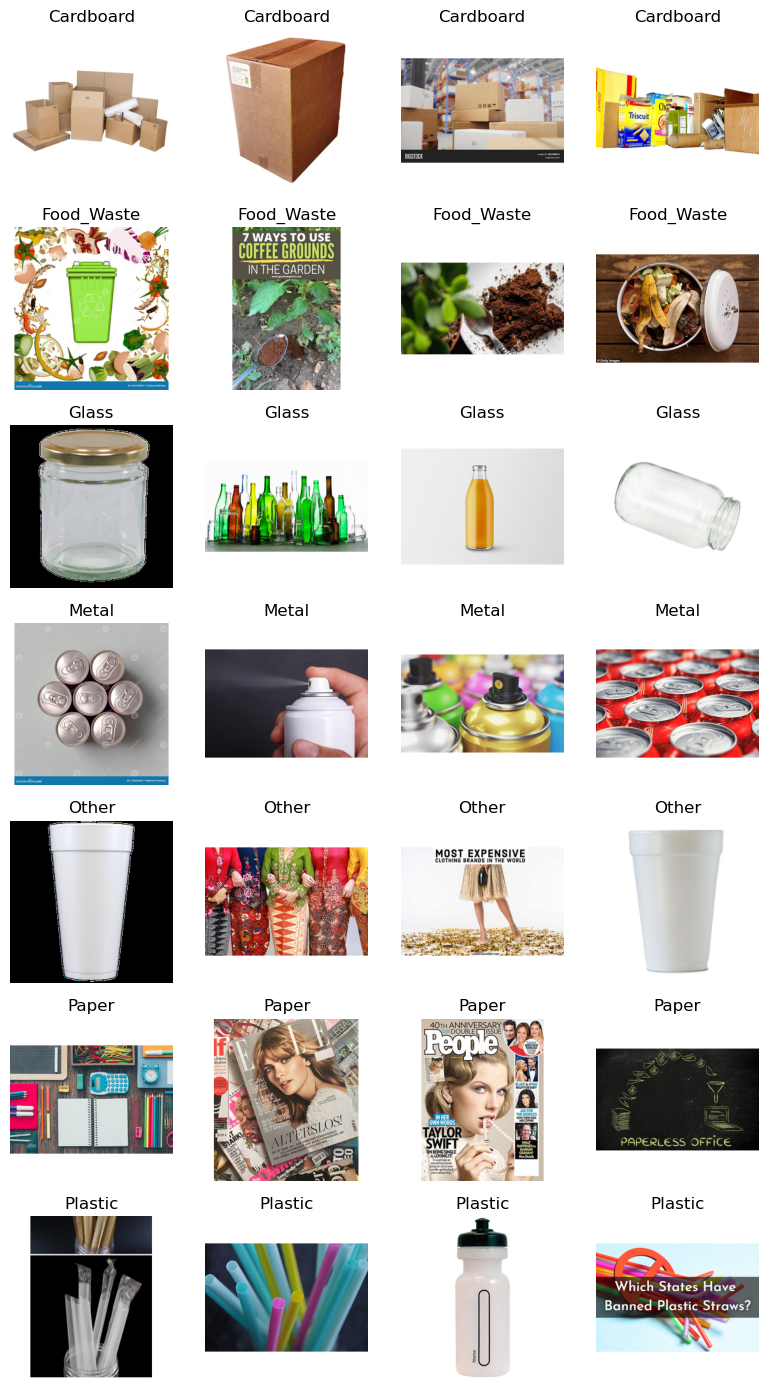

In [310]:
# Visualise Sample Images (across different labels)
def visualize_samples(images, labels, classes=None, samples_per_class=5):
    if classes is None:
        classes = sorted(set(labels))

    plt.figure(figsize=(samples_per_class * 2, len(classes) * 2))

    i = 1
    for class_name in classes:
        # Get indices of images belonging to this class
        class_indices = [idx for idx, label in enumerate(labels) if label == class_name][:samples_per_class]
        for idx in class_indices:
            plt.subplot(len(classes), samples_per_class, i)
            plt.imshow(images[idx])
            plt.title(class_name)
            plt.axis('off')
            i += 1

    plt.tight_layout()
    plt.show()


visualize_samples(images, labels, samples_per_class=4)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [311]:
# Find the smallest and largest image dimensions from the data set
def find_image_dimension_extremes(images):
    min_height, min_width = float('inf'), float('inf')
    max_height, max_width = 0, 0

    for img in images:
        h, w = img.shape[:2]
        min_height = min(min_height, h)
        min_width = min(min_width, w)
        max_height = max(max_height, h)
        max_width = max(max_width, w)

    return (min_height, min_width), (max_height, max_width)

find_image_dimension_extremes(images)

((256, 256), (256, 256))

In [312]:
# Resize the image dimensions
image_size = (32, 32)

def resize_images(images, target_size=(64, 64)):
    resized_images = []

    for img in images:
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize(target_size)
        resized_images.append(img_resized)
        
    return resized_images

resizeImages=resize_images(images,target_size=image_size)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [313]:
# Encode the labels suitably

def encode_labels(labels):
    le = LabelEncoder()
    encoded_labels = np.float64(le.fit_transform(labels))
    
    return encoded_labels, le

encoded_labels, le = encode_labels(labels)
print(le.classes_)           
print(encoded_labels)   


['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
[5. 5. 5. ... 6. 6. 6.]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [314]:
# Assign specified parts of the dataset to train and validation sets
X = np.array(images, dtype='float32')

def train_test_dsSplit(images, encoded_label):

    X = np.array(images, dtype='float32') / 255.0

    y = np.array(encoded_label)

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, random_state=42,train_size=0.8
        )
    return X_train, X_test, y_train, y_test 


X_train, X_test, y_train, y_test = train_test_dsSplit(resizeImages,encoded_labels)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [315]:
# Build and compile the model

def build_model(config, input_shape=(256, 256, 3), num_classes=7):

    model = Sequential()
    #         tf.keras.layers.RandomFlip(),
    # tf.keras.layers.RandomRotation(0.1),
    # tf.keras.layers.RandomZoom(0.1),
#])
    for idx, filters in enumerate([32, 128, 256]):
        if idx == 0:
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same',
                         input_shape=input_shape))
        else:
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        if config.get('use_bn'):
            model.add(GroupNormalization(groups=32))
        model.add(MaxPool2D(pool_size=(2, 2)))
        if config.get('use_do'):
            model.add(Dropout(config['dropout']))
    
    model.add(Flatten()) 
    model.add(Dense(config['dense_units'], activation='relu', kernel_regularizer=l2(config['lr'])))
    if config.get('extra_dropout'):
        model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [316]:
# Training

def training_with_config(X_train, y_train, X_test,y_test, configurations, epoch=30, image_size=(28,28,3), class_weights=None):

    # %reload_ext tensorboard
    if len(image_size) == 2:
        image_size =image_size + (3,)
    history_list = []
    for cfg in configurations:
        print(f"\nTraining config with ReduceLROnPlateau Scheduler {cfg['name']}")
        
        model=build_model(cfg, image_size)
        
        # Create a logs directory with timestamp
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,         
            write_graph=True,
            write_images=True,        
            update_freq='batch'       
        )
        lr_scheduler=None
        if cfg['lr']==0.0:
            lr_scheduler=None
        else:
            lr_scheduler = ReduceLROnPlateau(
                                            monitor='val_loss',
                                                factor=0.5,
                                                patience=3,
                                                verbose=1,
                                                min_lr=1e-6,
                                                cooldown=1
                                                  )
      
           
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history=model.fit(X_train,y_train,epochs=epoch, validation_data=(X_test,y_test),shuffle=True,callbacks=[tensorboard_callback,lr_scheduler,early_stop],class_weight=class_weights)
        history_list.append((cfg['name'], history))
        print(f'\n {model.summary()}')
        print(f'\n\n' )
       

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Classification report
        print(classification_report(y_test, y_pred_classes))
        labels = le.classes_

        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, display_labels=labels, cmap='Blues')
        plt.title("Confusion Matrix")

    return history_list, model



Training config with ReduceLROnPlateau Scheduler W/o Dropout and BN
Epoch 1/50
191/191 [==============================] - 8s 40ms/step - loss: 1.9315 - accuracy: 0.3275 - val_loss: 1.6792 - val_accuracy: 0.3502 - lr: 0.0010
Epoch 2/50
191/191 [==============================] - 9s 45ms/step - loss: 1.6430 - accuracy: 0.3831 - val_loss: 1.6418 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 3/50
191/191 [==============================] - 8s 42ms/step - loss: 1.5340 - accuracy: 0.4256 - val_loss: 1.5685 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 4/50
191/191 [==============================] - 8s 41ms/step - loss: 1.4630 - accuracy: 0.4639 - val_loss: 1.4348 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 5/50
191/191 [==============================] - 8s 40ms/step - loss: 1.3994 - accuracy: 0.4956 - val_loss: 1.4216 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 6/50
191/191 [==============================] - 8s 40ms/step - loss: 1.3263 - accuracy: 0.5326 - val_loss: 1.4264 - val_accuracy: 0.4898 - lr: 0.

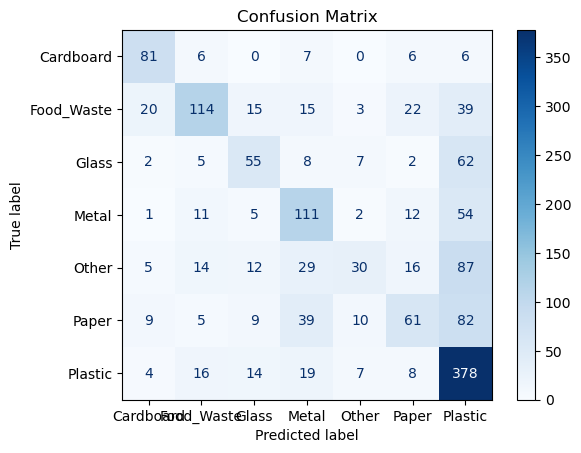

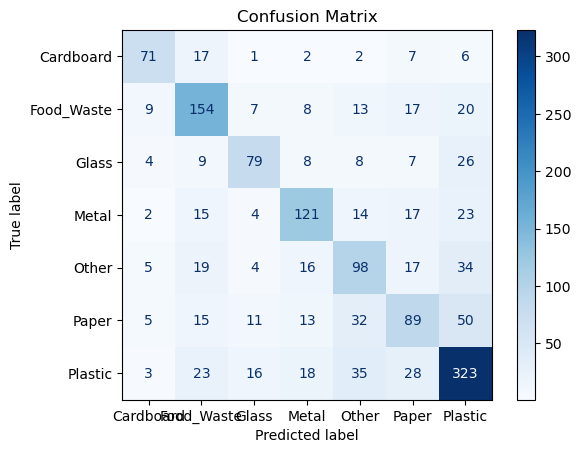

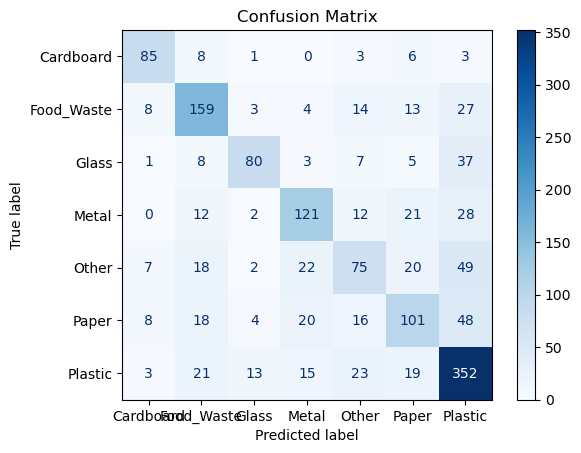

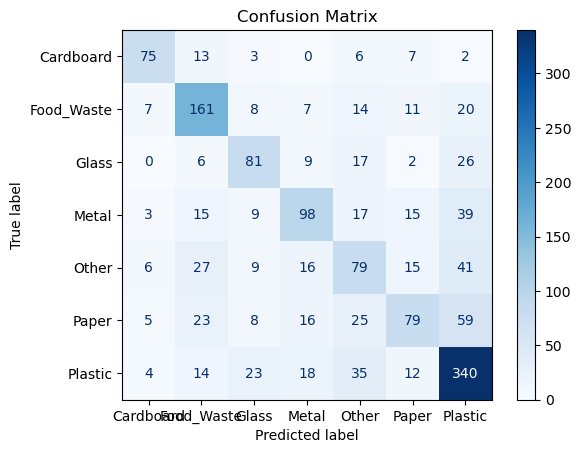

In [317]:

configurations = [
    {'name': 'W/o Dropout and BN', 'dropout': 0.25,'use_do': False, 'use_bn': False, 'dense_units': 512,'extra_dropout': False,'lr':0.001},
    {'name': 'W/o Dropout and with BN', 'dropout': 0.25,'use_do': False,  'use_bn': True, 'dense_units': 512,'extra_dropout': False,'lr':0.001},
    {'name': 'With Dropout and w/o BN', 'dropout': 0.25,'use_do': True,  'use_bn': False,'dense_units': 512,'extra_dropout': True,'lr':0.001},
    {'name': 'With Dropout and BN', 'dropout': 0.25, 'use_do': True, 'use_bn': True, 'dense_units': 512, 'extra_dropout': True,'lr':0.001}
]
history_list, model =training_with_config(X_train,y_train,X_test,y_test,configurations,50,image_size)

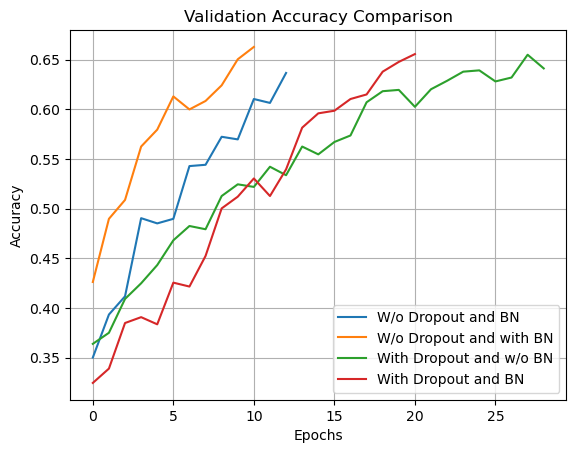

In [318]:
for name, hist in history_list:
    plt.plot(hist.history['val_accuracy'], label=f'{name}')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [319]:
# Evaluate on the test set; display suitable metrics

test_loss,test_acc= model.evaluate(X_test,y_test)

48/48 [==============================] - 1s 11ms/step - loss: 1.3630 - accuracy: 0.5987


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [320]:
# Define augmentation steps to augment images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,         # Add vertical flips
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0,   # Color shift
    fill_mode='nearest'
)
# Fit the data generator on the minority class samples
datagen.fit(X)



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [321]:
# Create a function to augment the images

def oversample_classes_with_augmentation(input_dir, output_dir, target_size=(128, 128)):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
   
    class_counts = {cls: len(os.listdir(os.path.join(input_dir, cls))) for cls in os.listdir(input_dir)}
    max_count = max(class_counts.values())+4000
    print("Original class distribution:", class_counts)
    print("Target count for all classes:", max_count)

    for cls in class_counts:
        src_class_dir = os.path.join(input_dir, cls)
        dst_class_dir = os.path.join(output_dir, cls)
        os.makedirs(dst_class_dir, exist_ok=True)

        images = os.listdir(src_class_dir)
        for img_file in images:
            shutil.copy(os.path.join(src_class_dir, img_file), os.path.join(dst_class_dir, img_file))

        current_count = len(images)
        needed = max_count - current_count
        print(f"Augmenting {needed} images for class: {cls}")

        while needed > 0:
            img_file = random.choice(images)
            img_path = os.path.join(src_class_dir, img_file)
            img = load_img(img_path, target_size=target_size)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=dst_class_dir, save_prefix='aug', save_format='jpg'):
                i += 1
                needed -= 1
                if needed <= 0 or i >= 5:
                    break

    print("Oversampled dataset saved at:", output_dir)
    return img


In [322]:
# # Create the augmented training dataset
oversample_classes_with_augmentation(
     input_dir='images/data/',
    output_dir='images/waste_balanced/',
    target_size=(28, 28)
)

Original class distribution: {'Paper': 1030, 'Food_Waste': 1000, 'Metal': 1000, 'Cardboard': 540, 'Other': 1010, 'Glass': 750, 'Plastic': 2295}
Target count for all classes: 6295
Augmenting 5265 images for class: Paper
Augmenting 5295 images for class: Food_Waste
Augmenting 5295 images for class: Metal
Augmenting 5755 images for class: Cardboard
Augmenting 5285 images for class: Other
Augmenting 5545 images for class: Glass
Augmenting 4000 images for class: Plastic
Oversampled dataset saved at: images/waste_balanced/


In [323]:
# load augmented images
images, labels = load_images_from_folder("images/waste_balanced")
print(f"Loaded {len(images)} images.")

Loaded 36001 images.


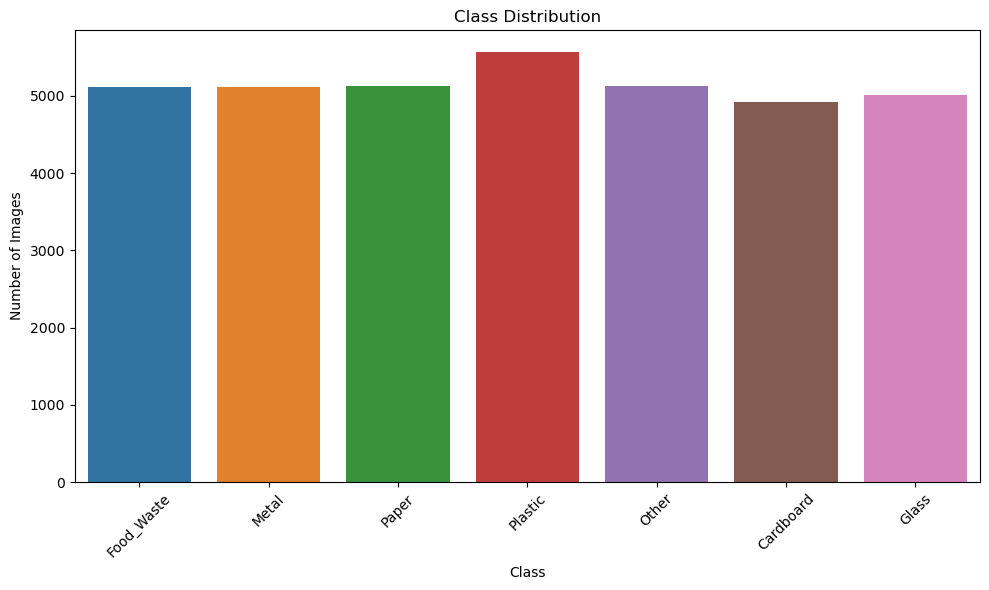

In [324]:
#visualize class distribution after augmentation
visualize_dist(class_labels,labels)

In [325]:
#encode lables
encoded_labels, le = encode_labels(labels)
print(le.classes_)           
print(encoded_labels)  

['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
[5. 5. 5. ... 6. 6. 6.]


In [326]:
# train and test split
X_train, X_test, y_train, y_test = train_test_dsSplit(resize_images(images,image_size), encoded_labels)

##### **4.1.2**

Train the model on the new augmented dataset.


Training config with ReduceLROnPlateau Scheduler W/o Dropout and BN
Epoch 1/30
900/900 [==============================] - 23s 25ms/step - loss: 1.7827 - accuracy: 0.2990 - val_loss: 1.6872 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 2/30
900/900 [==============================] - 23s 26ms/step - loss: 1.6317 - accuracy: 0.3843 - val_loss: 1.5817 - val_accuracy: 0.4024 - lr: 0.0010
Epoch 3/30
900/900 [==============================] - 25s 27ms/step - loss: 1.5689 - accuracy: 0.4118 - val_loss: 1.5358 - val_accuracy: 0.4269 - lr: 0.0010
Epoch 4/30
900/900 [==============================] - 25s 28ms/step - loss: 1.5180 - accuracy: 0.4407 - val_loss: 1.5319 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 5/30
900/900 [==============================] - 25s 28ms/step - loss: 1.4674 - accuracy: 0.4633 - val_loss: 1.4871 - val_accuracy: 0.4592 - lr: 0.0010
Epoch 6/30
900/900 [==============================] - 29s 32ms/step - loss: 1.4204 - accuracy: 0.4889 - val_loss: 1.4430 - val_accuracy: 0.4802 - 

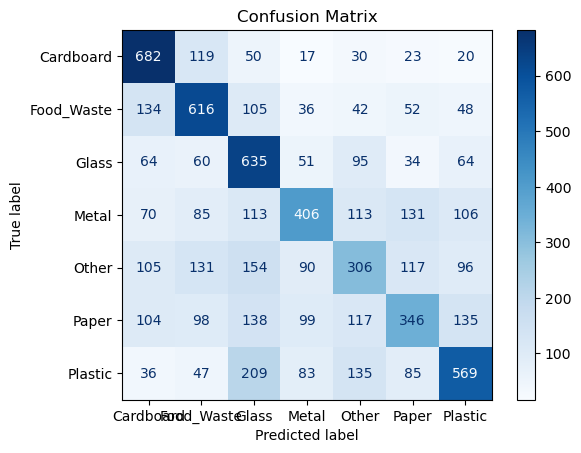

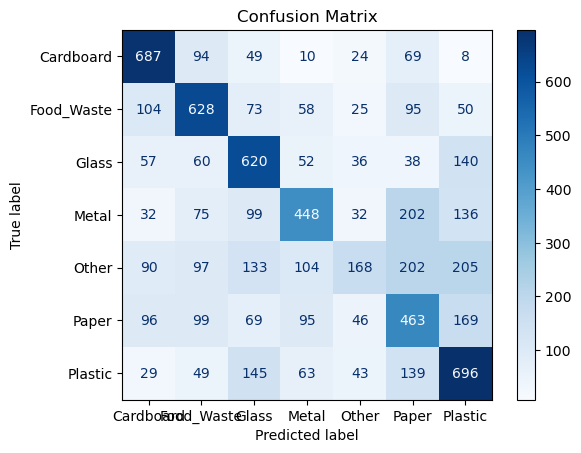

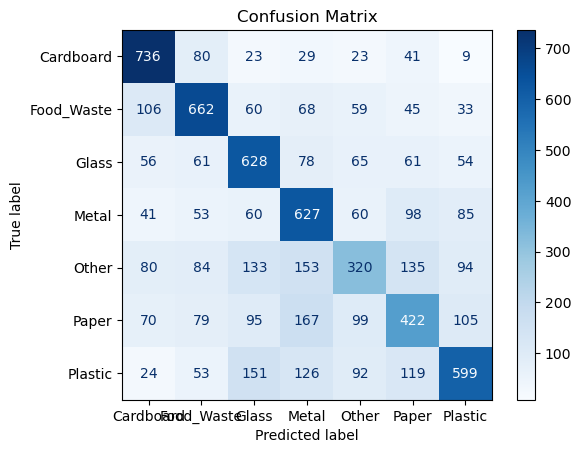

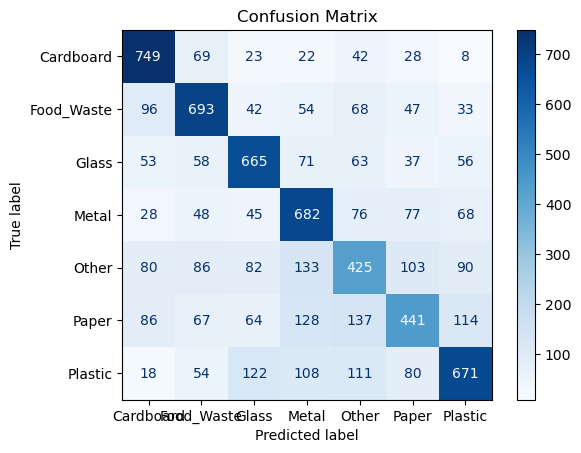

In [327]:
# Train the model using augmented images

configurations = [
    {'name': 'W/o Dropout and BN', 'dropout': 0.25,'use_do': False, 'use_bn': False, 'dense_units': 128,'extra_dropout': False,'lr':0.001},
    {'name': 'W/o Dropout and with BN', 'dropout': 0.25,'use_do': False,  'use_bn': True, 'dense_units': 128,'extra_dropout': False,'lr':0.001},
    {'name': 'With Dropout and w/o BN', 'dropout': 0.25,'use_do': True,  'use_bn': False,'dense_units': 512,'extra_dropout': True,'lr':0.001},
    {'name': 'With Dropout and BN', 'dropout': 0.25, 'use_do': True, 'use_bn': True, 'dense_units': 512, 'extra_dropout': True ,'lr':0.001}
]

history_list, model =training_with_config(X_train,y_train,X_test,y_test,configurations,30,image_size)

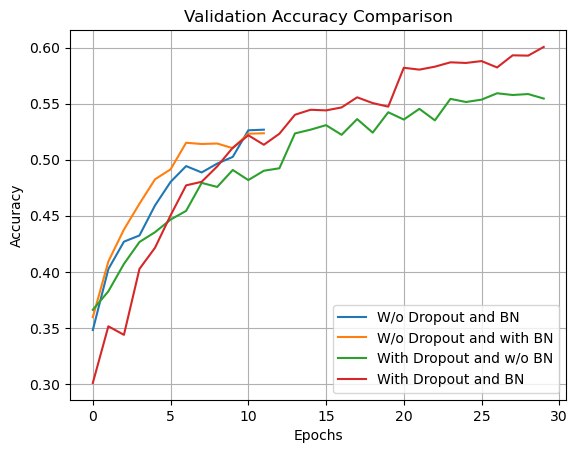

226/226 [==============================] - 6s 26ms/step - loss: 1.4215 - accuracy: 0.6007


In [328]:
for name, hist in history_list:
    plt.plot(hist.history['val_accuracy'], label=f'{name}')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

test_loss,test_acc= model.evaluate(X_test,y_test)

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

## * Report your findings about the data

###  Dataset Overview:
- **Type**: Multi-class classification (7 classes)
- **Classes**:  
  - `Cardboard`, `Food_Waste`, `Glass`, `Metal`, `Other`, `Paper`, `Plastic`
- **Imbalance Detected**:  
  - `Plastic` has significantly more samples (based on confusion matrix diagonal values) or majority class
   - `Cardboard` has significantly less samples or minority class
- **Preprocessing Likely Includes**:
  - Image resizing, normalization
  - Label encoding
  - Train-test split
  - image augmentation

### Confusion Matrix Observations:
- **Plastic** class performs best (e.g., `Plastic → Plastic: 340`)
- **Cardboard**, **Metal**, **Paper** show good classification
- **Food_Waste**, **Glass**, and **Other** show more misclassifications:
  - `Glass → Plastic` and `Glass → Metal` are common errors
  - `Food_Waste → Plastic` occurs often
  - `Other` is confused with several categories

---

## * Report model training results

All models used `ReduceLROnPlateau` for dynamic learning rate adjustment.

| Model Variant                 | Generalization  | Normalization | Best Val Accuracy  | Notes               |
| ----------------------------- | --------------  | ------------- | -----------------  | ------------------- |
| **1. No Dropout / No BN**     | ❌              | ❌             | ~0.63              | Overfits quickly    |
| **2. No Dropout / With BN**   | ❌              | ✅             | **~0.66**          | Fastest convergence |
| **3. With Dropout / No BN**   | ✅              | ❌             | ~0.64              | Slow but steady     |
| **4. With Dropout / With BN** | ✅              | ✅             | ~0.65              | Best generalization | 

### Key Takeaways:
- **Batch Normalization** improves training speed and initial accuracy
- **Dropout** improves generalization, especially with longer training
- **Dropout + BN** (Model 4) is the most stable and generalizable with fast convergence
- `ReduceLROnPlateau` helped fine-tune learning in slower-converging models

---

## Final Recommendation

> Use **Model 4 (Dropout + Batch Normalization)** for balanced generalization and robustness  
> Use **Model 2 (BN only)** for faster convergence in time-constrained settings

###  Conclusion (Augmented Dataset)
- Augmentation helped mitigate overfitting and improved the model's performance and robustness.

- The model is more stable and accurately distinguishes between high-similarity classes better than before.

####  Still, additional improvements could focus on:

- Further augmenting the "Other" class or splitting it into more specific sub-categories.

- Using class-balanced loss or focal loss to better handle confusing samples.

- Model ensembling or Transfer learning for further performance boost.